In [1]:
%load_ext autoreload

import numpy as np
import numpy.random as npr
import torch
import scipy as sp
from scipy import interpolate
from collections import defaultdict

import json
import pandas as pd
import os
from tqdm import tqdm
pd.set_option('display.max_rows', None)

import matplotlib.pyplot as plt
plt.style.use('bmh')
from matplotlib import cm
plt.rcParams.update({'figure.max_open_warning': 0})
import seaborn as sns

import dmc2gym

import pickle as pkl
import itertools
import operator
from collections import namedtuple
from glob import glob
import textwrap

import os
import yaml

import sys
# sys.path.append('../batch')
# %autoreload 2
# %aimport bcq

import omegaconf
from omegaconf import OmegaConf

sys.path.append('..')
%autoreload 2
from common.analysis import plot_ac_exp

from IPython.display import display
%matplotlib inline

In [2]:
def sweep_summary(root):
    configs = {}
    all_summary = []
    for d in glob(f'{root}/*/'):
        eval_f = f'{d}/eval.csv'
        try:
            eval_df = pd.read_csv(eval_f)
        except:
            continue
        print
#         last_eval_rew = eval_df.episode_reward.values[-10:].mean()
        last_eval_rew = eval_df.episode_reward.values[-1]
        best_eval_rew = eval_df.episode_reward.values.max()
        fname = f'{d}/config.yaml'
        if not os.path.exists(fname):
            fname = f'{d}/.hydra/config.yaml'
            assert os.path.exists(fname)
        config = OmegaConf.load(fname)
        configs[d] = config
        fname = f'{d}/overrides.yaml'
        if not os.path.exists(fname):
            fname = f'{d}/.hydra/overrides.yaml'
            assert os.path.exists(fname)
        overrides = OmegaConf.load(fname)
        summary = dict(x.split('=') for x in overrides)
        summary['best_eval_rew'] = best_eval_rew
        summary['last_eval_rew'] = last_eval_rew
        summary['d'] = d
        summary['env_name'] = config.env_name
        all_summary.append(summary)
    
    if len(all_summary) == 0:
        print('No experiments with eval data found.')
        return [None]*4
        
    all_summary = pd.DataFrame(all_summary)
    for col in all_summary.columns:
        if col != 'env_name' and len(all_summary[col].unique()) == 1:
            all_summary.drop(col,inplace=True,axis=1)

    filt = ['env_name', 'seed']
    groups = [x.split('=')[0] for x in overrides]
    groups = [x for x in groups if x not in filt]
    groups = list(set(groups) & set(all_summary.columns))
    groups = ['env_name'] + groups
    groups = all_summary.groupby(groups)
    agg = groups.agg(['mean', 'std'])

    return all_summary, groups, agg, configs

def plot_rew(root, ax=None, label=None):
    if ax is None:
        nrow, ncol = 1, 1
        fig, ax = plt.subplots(nrow, ncol, figsize=(6*ncol, 4*nrow))
        ax.set_xlabel('1k Updates')
    
    try:
        eval_df = pd.read_csv(f'{root}/eval.csv')
    except:
        return
    l, = ax.plot(eval_df.step/1000, eval_df.episode_reward, label=label)

def plot_rew_list(ds, title=None, ax=None):
    nrow, ncol = 1, 1
    if ax is None:
        fig, ax = plt.subplots(nrow, ncol, figsize=(6*ncol, 4*nrow))
    ax.set_xlabel('1k Updates')
#     ax.set_ylim(0, 1000)
    if title is not None:
        ax.set_title(title)
    for d in ds:
        label = d.split('/')[-2]
        plot_rew(d, ax=ax, label=label)
    ax.legend()

def plot_all_rew(root):
    nrow, ncol = 1, 1
    fig, ax = plt.subplots(nrow, ncol, figsize=(6*ncol, 4*nrow))
    ax.set_xlabel('1k Updates')
    title = '/'.join(root.split('/')[-3:])
    ax.set_title(title)
#     ax.set_ylim(0, 1000)
    for d in glob(f'{root}/*/'):
        label = d.split('/')[-2]
        plot_rew(d, fig=fig, label=label)
    ax.legend()

def plot_agg(df, agg, ncol=4):
    nrow = int(np.ceil(len(agg)/ncol))
    fig, axs = plt.subplots(nrow, ncol, figsize=(6*ncol, 4*nrow))
    if nrow == 1 and ncol == 1:
        axs = [axs]
    else:
        axs = axs.ravel()
    for ax, (r, sub_df) in zip(axs, agg.iterrows()):
        if isinstance(r, str):
            r = [r]
        I = df.index == df.index
        for k, v in zip(agg.index.names, r):
            I = I & (df[k] == v)
        df_I = df[I]
        title = '.'.join([f'{k}={v}' for k,v in zip(agg.index.names, r)])
        title = title.replace('agent.params.', '').replace('model.params.', '')
        title = '\n'.join(textwrap.wrap(title, 45))
        plot_rew_list(df_I.d.values, title=title, ax=ax)
    fig.tight_layout()

def plot_ablation(
    groups, title, xmax=None,
    save=None, lw=3,
    xlabel='Timestep', ylabel='Reward',
    legend=False, sac_lim=None
):
    fig, ax = plt.subplots(1, 1, figsize=(4.5,3))

    for group in groups:
        all_df = []
        min_step = None
        for root in group['roots']:
            eval_f = f'{root}/eval.csv'
            df = pd.read_csv(eval_f)
            if min_step is None or max(df['step']) < min_step:
                min_step = max(df['step'])
            df['f'] = eval_f
            all_df.append(df)

        step_interp = np.linspace(0, min_step, num=20)
        all_df_interp = []
        for df in all_df:
            rew_interp = np.interp(step_interp, df['step'], df['episode_reward'])
            df_interp = pd.DataFrame({'step': step_interp, 'rew': rew_interp})
            all_df_interp.append(df_interp)
        all_df_interp = pd.concat(all_df_interp)
        label = group['tag'] if legend else None
        if 'color' in group:
            sns.lineplot(x='step', y='rew', data=all_df_interp,
                         ax=ax, linewidth=lw, label=label, color=group['color'])
        else:
            sns.lineplot(x='step', y='rew', data=all_df_interp,
                         ax=ax, linewidth=lw, label=label)
                
    ax.axhline(sac_lim, lw=lw, linestyle='--', color='k')

    ax.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    if xmax is not None:
        ax.set_xlim(0, xmax)

    ax.set_xlabel('Timestep')
    ax.set_ylabel('Reward')
    ax.set_title(title)
    fig.tight_layout()
    
    if save is not None:
        fig.savefig(save)
        os.system(f'convert -trim {save} {save}')

best_eval_rew            last_eval_rew  \
                                        mean        std          mean   
env_name      obs_enc                                                   
mbpo_walker2d proprio_MLP        5297.791155  466.89308   4925.237811   
              proprio_identity   5753.981348  509.66195   5284.118690   

                                            
                                       std  
env_name      obs_enc                       
mbpo_walker2d proprio_MLP       796.997315  
              proprio_identity  490.111630

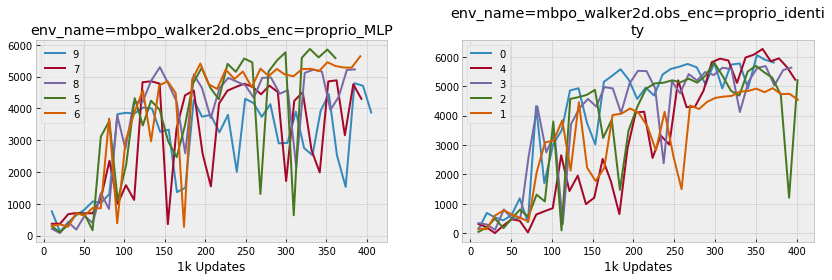

In [3]:
d = '../exp/2020.03.05/1620_sac_mve_walker_enc/'
all_summary, groups, agg, configs = sweep_summary(d)
# display(all_summary)
display(agg)
plot_agg(all_summary, agg, ncol=2)

['env=mbpo_walker2d', 'obs_enc=proprio_MLP', 'experiment=walker_enc', 'seed=1']


(<Figure size 1296x576 with 7 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fb7440380f0>,
       dtype=object))

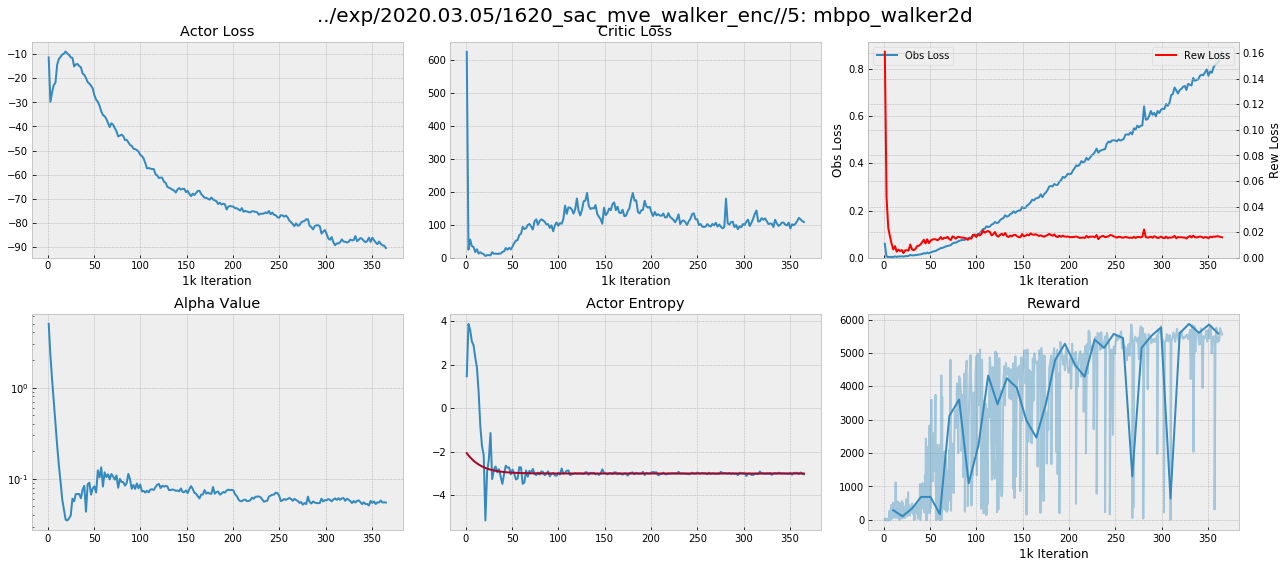

In [5]:
plot_ac_exp(f'{d}/5')

best_eval_rew  \
                                                                                                                           mean   
env_name      agent.params.obs_latent_step_penalty agent.params.obs_recon_penalty agent.params.obs_latent_penalty                 
mbpo_walker2d 0.                                   0.                             0.                                4222.186610   
                                                                                  1e-4                              3977.614540   
                                                   1e-4                           0.                                4538.035269   
                                                                                  1e-4                              4302.526901   
              1e-4                                 0.                             0.                                3725.578881   
                                                                                  1e-4                              4122.526813   
                                                   1e-4                           0.                                4552.054730   
                                                                                  1e-4                              4017.138186   

                                                                                                                               \
                                                                                                                          std   
env_name      agent.params.obs_latent_step_penalty agent.params.obs_recon_penalty agent.params.obs_latent_penalty               
mbpo_walker2d 0.                                   0.                             0.                               473.734256   
                                                                                  1e-4                             253.826613   
                                                   1e-4                           0.                               381.900870   
                                                                                  1e-4                             410.042529   
              1e-4                                 0.                             0.                               597.917849   
                                                                                  1e-4                             532.471495   
                                                   1e-4                           0.                               250.870199   
                                                                                  1e-4                             483.327576   

                                                                                                                  last_eval_rew  \
                                                                                                                           mean   
env_name      agent.params.obs_latent_step_penalty agent.params.obs_recon_penalty agent.params.obs_latent_penalty                 
mbpo_walker2d 0.                                   0.                             0.                                3717.926681   
                                                                                  1e-4                              2842.463956   
                                                   1e-4                           0.                                3765.223040   
                                                                                  1e-4                              2894.176577   
              1e-4                                 0.                             0.                                2905.570827   
                                                                                  1e-4                              3492.443464   
                                                   1e-4                  

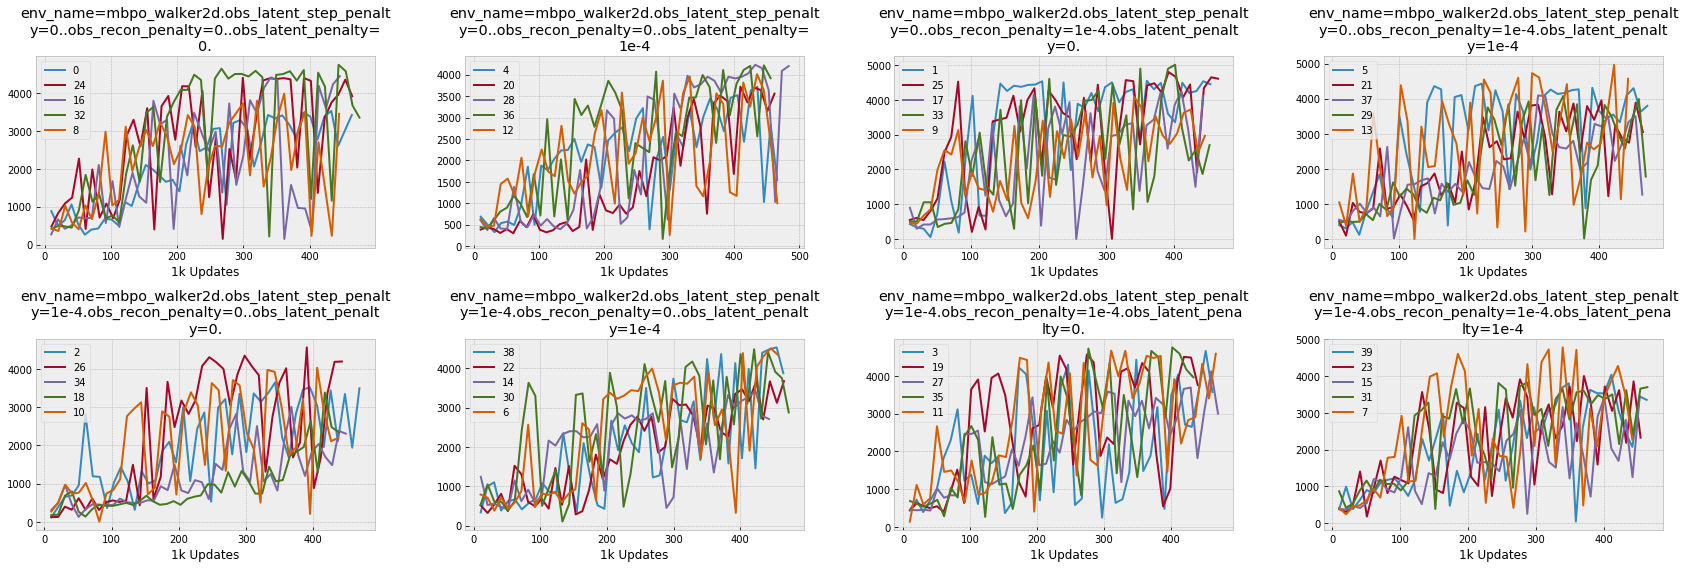

In [6]:
d = '../exp/2020.03.10/1237_sac_mve_walker_enc_MLP/'
all_summary, groups, agg, configs = sweep_summary(d)
# display(all_summary)
display(agg)
plot_agg(all_summary, agg, ncol=4)

,best_eval_rew,d,env_name,last_eval_rew,seed
0,4513.103098,../exp/2020.03.12/1440_sac_mve_walker_enc_MLP/2/,mbpo_walker2d,3672.533932,3
1,5077.542243,../exp/2020.03.12/1440_sac_mve_walker_enc_MLP/3/,mbpo_walker2d,3839.858043,4
2,4562.312909,../exp/2020.03.12/1440_sac_mve_walker_enc_MLP/0/,mbpo_walker2d,1397.098340,1
3,4454.742069,../exp/2020.03.12/1440_sac_mve_walker_enc_MLP/4/,mbpo_walker2d,3996.007426,5
4,4593.798051,../exp/2020.03.12/1440_sac_mve_walker_enc_MLP/1/,mbpo_walker2d,4366.874825,2


best_eval_rew             last_eval_rew             
                       mean         std          mean          std
env_name                                                          
mbpo_walker2d   4640.299674  250.017996   3454.474513  1178.409873

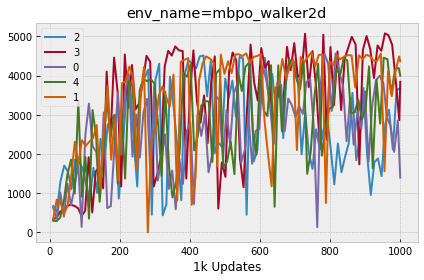

In [7]:
d = '../exp/2020.03.12/1440_sac_mve_walker_enc_MLP/'
all_summary, groups, agg, configs = sweep_summary(d)
display(all_summary)
display(agg)
plot_agg(all_summary, agg, ncol=1)

best_eval_rew             last_eval_rew  \
                                     mean         std          mean   
env_name      env                                                     
mbpo_ant      mbpo_ant        8228.888545  678.425975   8181.565566   
mbpo_cheetah  mbpo_cheetah   15444.379813  518.602455  14969.617593   
mbpo_hopper   mbpo_hopper     3797.811469   90.471282   3690.394469   
mbpo_humanoid mbpo_humanoid   7702.347071  677.665838   7396.954240   
mbpo_walker2d mbpo_walker2d   5611.831024  154.343506   5447.073522   

                                         
                                    std  
env_name      env                        
mbpo_ant      mbpo_ant       706.638879  
mbpo_cheetah  mbpo_cheetah   665.121303  
mbpo_hopper   mbpo_hopper    155.933239  
mbpo_humanoid mbpo_humanoid  426.023948  
mbpo_walker2d mbpo_walker2d  202.446126

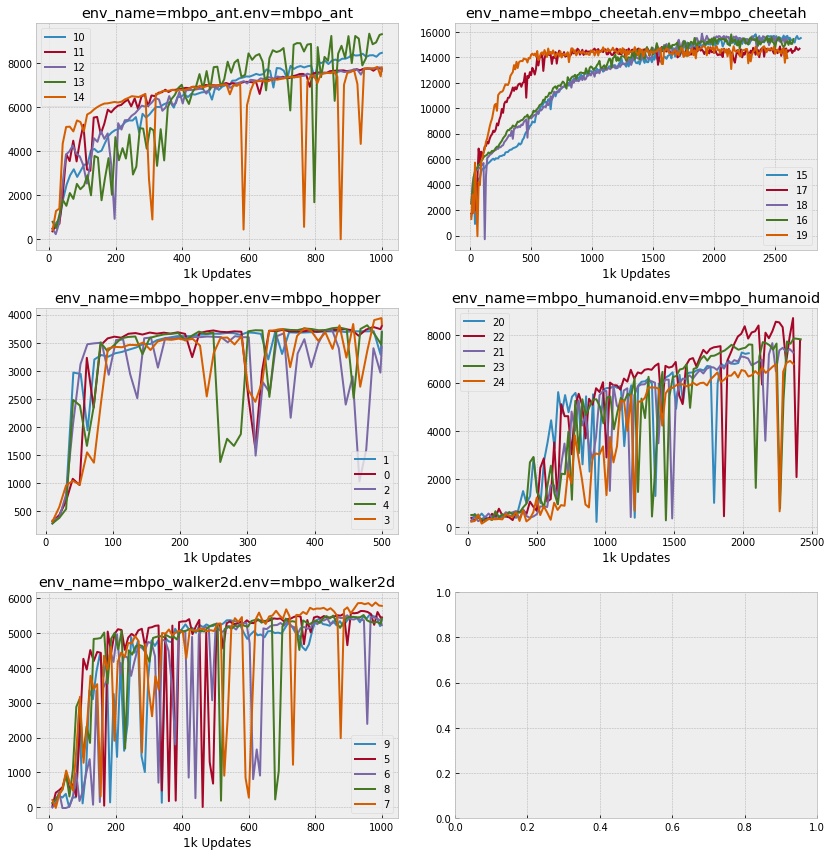

In [11]:
d = '../exp/2020.03.16/1851_sac_mve_mbpo/'
all_summary, groups, agg, configs = sweep_summary(d)
# display(all_summary)
display(agg)
plot_agg(all_summary, agg, ncol=2)